Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Intentar modificar el numero de capas e implementar el decoder

In [10]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [11]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [12]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [13]:
#Datos de entrenamiento 80%
ShanghaiDat_train=ShanghaiDat.iloc[:, 0:3900]
#Datos de prueba 20%
ShanghaiDat_test=ShanghaiDat.iloc[:, 3900:]


In [14]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

#Convertimos los datos a un array de 1 dimension (tomamos los datos de entrenamiento)
ShanghaiDat_train = np.array(ShanghaiDat_train).flatten()

#Aplicamos MinMaxScaler a los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ShanghaiDat_train = scaler.fit_transform(ShanghaiDat_train.reshape(-1, 1)).flatten()


#Dividimos en epocas de n dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat_train) 
    sequences = [ShanghaiDat_train[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat_train[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)


In [15]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [16]:
#Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, seq_len=12, d_model=64, num_layers=4, num_heads=4, dim_feedforward=128):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)  # Embedding input to d_model
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, 1, d_model))  # Learnable PE
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(seq_len * d_model, 1)

    def forward(self, src):
        # src: [batch, seq_len, input_size]
        src = src.permute(1, 0, 2)  # [seq_len, batch, input_size]
        src = self.input_proj(src) + self.pos_encoding  # [seq_len, batch, d_model]
        encoded = self.encoder(src)  # [seq_len, batch, d_model]
        encoded = encoded.permute(1, 0, 2).flatten(1)  # [batch, seq_len * d_model]
        return self.fc_out(encoded)


In [17]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [18]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

#Training loop
losses=[]
for epoch in range(600):
    for seq, next_point in dataloader:
        seq = seq.float().unsqueeze(-1).to(device)         # [batch, seq_len, 1]
        next_point = next_point.float().unsqueeze(1).to(device)  # [batch, 1]
        output = model(seq)
        loss = criterion(output, next_point)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.011916848830878735
Epoch 2, Loss: 0.010693336836993694
Epoch 3, Loss: 0.002801464404910803
Epoch 4, Loss: 0.006673967465758324
Epoch 5, Loss: 0.0025603361427783966
Epoch 6, Loss: 0.0049570901319384575
Epoch 7, Loss: 0.0026881478261202574
Epoch 8, Loss: 0.0021714502945542336
Epoch 9, Loss: 0.0021345920395106077
Epoch 10, Loss: 0.001458604820072651
Epoch 11, Loss: 0.0007065810495987535
Epoch 12, Loss: 0.001237670425325632
Epoch 13, Loss: 0.0004351667012088001
Epoch 14, Loss: 0.0006771890912204981
Epoch 15, Loss: 0.0005848703440278769
Epoch 16, Loss: 0.0005034240894019604
Epoch 17, Loss: 0.0010043851798400283
Epoch 18, Loss: 0.0007861432386562228
Epoch 19, Loss: 0.000456929235951975
Epoch 20, Loss: 0.0005376325570978224
Epoch 21, Loss: 0.0006097883451730013
Epoch 22, Loss: 0.0006350810290314257
Epoch 23, Loss: 0.0011380193755030632
Epoch 24, Loss: 0.001207398483529687
Epoch 25, Loss: 0.0004718745476566255
Epoch 26, Loss: 0.000276874314295128
Epoch 27, Loss: 0.000451280793

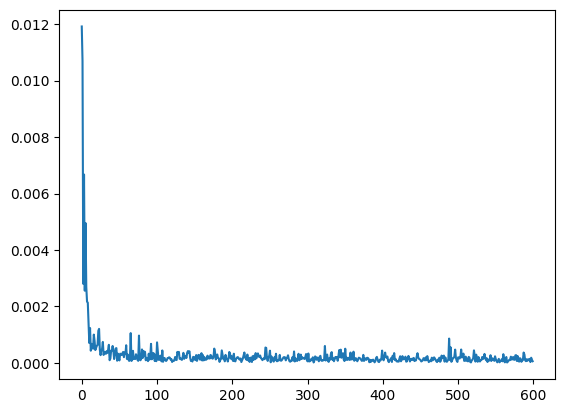

In [19]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [21]:
# Veamos cómo predice el modelo

# Tomamos una secuencia ya escalada (por ejemplo, la primera del dataset)
test_seq = sequences[0].reshape(-1, 1)  # La convertimos a forma columna
test_seq = scaler.transform(test_seq).flatten()  # La reescalamos (aunque ya estaba escalada, es por claridad y generalidad)

# Convertimos a tensor y agregamos dimensión de batch y de input_size
test_seq_tensor = torch.tensor(test_seq).float().unsqueeze(0).unsqueeze(-1).to(device)  # [1, seq_len, 1]

# Obtenemos la predicción del modelo
with torch.no_grad():
    predicted_scaled = model(test_seq_tensor)

# Convertimos de vuelta a numpy
predicted_scaled_np = predicted_scaled.cpu().numpy()

# Desescalamos la predicción a su valor original
predicted_real = scaler.inverse_transform(predicted_scaled_np)

print("Predicción:", predicted_real.item())
print("Dato siguiente real:", scaler.inverse_transform([[next_points[0]]])[0][0])


Predicción: 729.31201171875
Dato siguiente real: 1204.39404296875


In [23]:
#Comparemos los datos reales con las predicciones que hace el modelo
predicciones = []
for i in sequences:
    test_seq = torch.tensor(i).float().unsqueeze(0).unsqueeze(-1).to(device)  # [1, seq_len, 1]
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


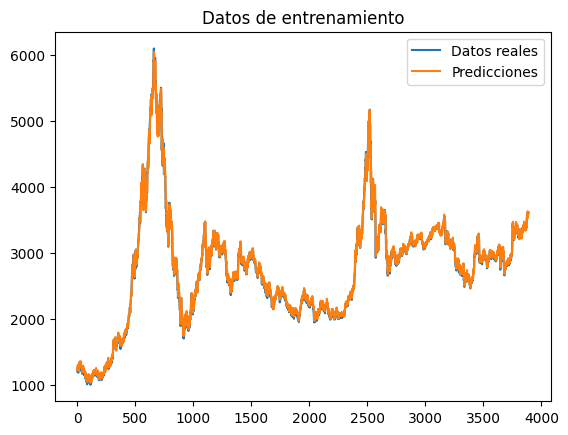

In [24]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(ShanghaiDat_train.reshape(-1, 1))

ShanghaiDat_desnormalizado = ShanghaiDat_desnormalizado[12:] #Ignoramos los primeros 12 datos reales, pues la primera prediccion corresponde al dato real numero 13

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicciones')
plt.title('Datos de entrenamiento')
plt.legend()
plt.show()

In [25]:
print(len(predicciones_desnormalizadas))
print(len(ShanghaiDat_desnormalizado))

3888
3888


In [27]:
'''Ahora con los datos de prueba (20% = 975)'''
valores_reales = np.array(ShanghaiDat_test).flatten()

#Aplicamos MinMaxScaler a los datos
valores_reales = scaler.fit_transform(valores_reales.reshape(-1, 1)).flatten()

#Dividimos los datos en ventanas deslizantes
def Epocas2(sequence_length=12):
    size = len(valores_reales) 
    sequences = [valores_reales[i:i+sequence_length] for i in range(size-sequence_length)]

    return np.array(sequences)

sequences = Epocas2()


predicciones = []
for i in sequences:
    test_seq = torch.tensor(i).float().unsqueeze(0).unsqueeze(-1).to(device)  # [1, seq_len, 1]
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


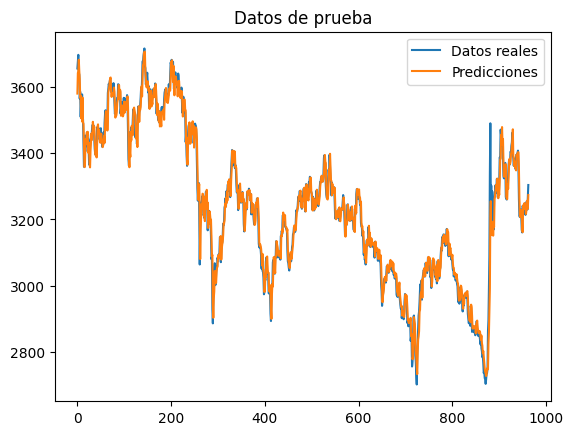

In [28]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(valores_reales.reshape(-1, 1))

ShanghaiDat_desnormalizado = ShanghaiDat_desnormalizado[12:] #Ignoramos los primeros 12 datos reales, pues la primera prediccion corresponde al dato real numero 13

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicciones')
plt.title('Datos de prueba')
plt.legend()
plt.show()